## Описание задачи  

Задачи заключается в прогнозировании выручки компании в зависимости от уровня ее инвестиций в рекламу по TV, в газетах и по радио используя линейную регрессию и стохастический градиентный спуск.  

## Подключение библиотек

In [0]:
import pandas as pd
import numpy as np


## Знакомство с данными

In [95]:
df = pd.read_csv(r'https://d3c33hcgiwev3.cloudfront.net/_739f9073ae55f970a4924e22bcc93124_advertising.csv?Expires=1563667200&Signature=O2ko6l3J-VMw~B72oE0EJQZkYuin-WwKcD1el8NhbA2ynWQEYr6QgkBY-zqZutjzWSEoa8RWMIPVhOgf9rG3CCI81cow~qqJ3OCXat7CzaxgcnywJ1IrFgGnBMGPZNKD6NtCBfR8AeBZx1~WtB~zhgMawIJjyJMPprTnkwWTkmA_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A')
df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Текущий датасет представляет собой комбинацию инвестиций в 3 медийных канала (TV	Radio	Newspaper) и последующий уровень продаж Sales,  зависимость которого от уровня инвестиций мы попробуем аппроксимировать.

In [96]:
print('Количество пропущенных значений в датасете: {}'.format(df.isna().sum().sum()))
df.info()

Количество пропущенных значений в датасете: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB


## Предобработка данных  

Подготовим функцию для записи ответов в текстовый файл

In [0]:
def write_answer_to_file(answer, filename):
    with open(filename, 'w') as f_out:
        f_out.write(str(round(answer, 3)))

Создадим  массивы NumPy X из столбцов TV, Radio и Newspaper и y - из столбца Sales

In [0]:
X = np.array(df.drop('Sales', axis=1).values)
y = np.array(df['Sales'])

Отмасштабируем столбцы матрицы X, вычтя из каждого значения среднее по соответствующему столбцу и поделив результат на стандартное отклонение

In [109]:
means, stds = np.mean(X,axis=0), np.std(X, axis=0)
means, stds

(array([147.0425,  23.264 ,  30.554 ]),
 array([85.63933176, 14.80964564, 21.72410606]))

In [0]:
X = (X-means)/stds

Добавим к матрице X столбец из единиц. Вектор из единиц нужен для того, чтобы не обрабатывать отдельно коэффициент $w_0$
  линейной регрессии.

In [0]:
n = np.shape(X)[0]
ones = np.reshape(np.ones(n),(n,1))

X = np.hstack((X,ones))

Реализуем функцию mserror - среднеквадратичную ошибку прогноза. Она принимает два аргумента - объекты Series y (значения целевого признака) и y_pred (предсказанные значения)

In [0]:
def mserror(y, y_pred):
  return np.mean((y-y_pred)**2)

## Какова среднеквадратичная ошибка прогноза значений Sales, если всегда предсказывать медианное значение Sales по исходной выборке?

In [113]:
answer1 = mserror(y, np.median(y))
print(answer1)
write_answer_to_file(answer1, '1.txt')

28.34575


## Какие продажи предсказываются линейной моделью с весами, найденными с помощью нормального уравнения, в случае средних инвестиций в рекламу по ТВ, радио и в газетах? (то есть при нулевых значениях масштабированных признаков TV, Radio и Newspaper)

Реализуем функцию normal_equation, которая по заданным матрицам (массивам NumPy) X и y вычисляет вектор весов ww согласно нормальному уравнению линейной регрессии.

In [0]:
def normal_equation(X, y):
    return np.linalg.solve(np.dot(X.transpose(),X), np.dot(X.transpose(),y))

In [116]:
norm_eq_weights = normal_equation(X, y)
print(norm_eq_weights)

[ 3.91925365  2.79206274 -0.02253861 14.0225    ]


In [117]:
answer2 = np.sum([0., 0., 0., 1.]*norm_eq_weights)
print(answer2)
write_answer_to_file(answer2, '2.txt')

14.022500000000003


## Какова среднеквадратичная ошибка прогноза значений Sales в виде линейной модели с весами, найденными с помощью нормального уравнения?   

Напишем функцию linear_prediction, которая принимает на вход матрицу X и вектор весов линейной модели w, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы X с весами w

In [0]:
def linear_prediction(X, w):
    return np.dot(X,w)

In [119]:
lin_pred = linear_prediction(X,norm_eq_weights)
answer3 = mserror(y,lin_pred)
print(answer3)
write_answer_to_file(answer3, '3.txt')

2.784126314510936


## Какова среднеквадратичная ошибка прогноза значений Sales в виде линейной модели с весами, найденными с помощью градиентного спуска?  

Напишем функцию stochastic_gradient_step, реализующую шаг стохастического градиентного спуска для линейной регрессии. Функция должна принимать матрицу X, вектора y и w, число train_ind - индекс объекта обучающей выборки (строки матрицы X), по которому считается изменение весов, а также число $\eta$ (eta) - шаг градиентного спуска (по умолчанию eta=0.01). Результатом будет вектор обновленных весов.

In [0]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    return w + 2 * eta/X.shape[0] * X[train_ind] * (y[train_ind] - linear_prediction(X[train_ind], w))

Напишите функцию stochastic_gradient_descent, реализующую стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:

* X - матрица, соответствующая обучающей выборке
* y - вектор значений целевого признака
* w_init - вектор начальных весов модели
* eta - шаг градиентного спуска (по умолчанию 0.01)
* max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
* max_weight_dist - минимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска, при котором алгоритм прекращает работу (по умолчанию 1e-8)
* seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
* verbose - флаг печати информации (например, для отладки, по умолчанию False)  

На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.

In [0]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        
        w_new = stochastic_gradient_step(X, y, w, random_ind, eta)
        weight_dist = np.linalg.norm(w-w_new)
        w = w_new
        errors.append(mserror(y, linear_prediction(X, w)))
        iter_num += 1

        
    return w, errors

Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов w_init, состоящий из нулей. Оставьте параметры eta и seed равными их значениям по умолчанию (eta=0.01, seed=42 - это важно для проверки ответов).

In [122]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, np.zeros(X.shape[1]),max_iter=1e5)

CPU times: user 2.94 s, sys: 0 ns, total: 2.94 s
Wall time: 2.94 s


Посмотрим, чему равна ошибка на первых 50 итерациях стохастического градиентного спуска. Видим, что ошибка не обязательно уменьшается на каждой итерации.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['ones']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'MSE')

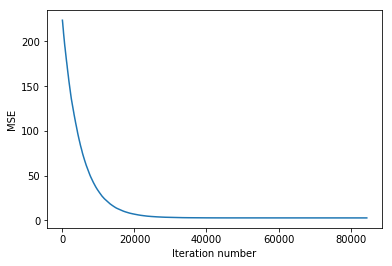

In [123]:
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

Посмотрим на вектор весов, к которому сошелся метод.

In [124]:
stoch_grad_desc_weights


array([ 3.91069256e+00,  2.78209808e+00, -8.10462217e-03,  1.40190566e+01])

Посмотрим на среднеквадратичную ошибку на последней итерации.

In [125]:
stoch_errors_by_iter[-1]


2.784412588406704

In [126]:
answer4 = mserror(y, linear_prediction(X, stoch_grad_desc_weights))
print(answer4)
write_answer_to_file(answer4, '4.txt')

2.784412588406704
